In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

### Loading and normalizing CIFAR10

In [2]:
# Define transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████████████████████████████████████████████████████████▉| 170352640/170498071 [01:09<00:00, 3626006.48it/s]

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


170500096it [01:20, 3626006.48it/s]                                                                                    

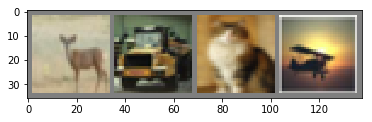

 deer truck   cat plane


In [4]:
# Visualize
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def imshow(img):
    img = img/2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Define a Convolutional Neural Network

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        # 3 channels, 6 filters, kernel size 5x5
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
mynet = MyNet()

### Define a Loss function and optimizer

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mynet.parameters(), lr=0.001, momentum=0.9)

### Train the network

In [12]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        outputs = mynet(inputs) # feed inputs into the model
        loss = criterion(outputs, labels) # calcul loss
        loss.backward() # backpropagation
        optimizer.step() # update weights
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f'%(epoch+1, i+1, running_loss/2000))
            running_loss = 0
print('Finished training...')

[1,  2000] loss: 2.168
[1,  4000] loss: 1.845
[1,  6000] loss: 1.647
[1,  8000] loss: 1.578
[1, 10000] loss: 1.521
[1, 12000] loss: 1.482
[2,  2000] loss: 1.410
[2,  4000] loss: 1.379
[2,  6000] loss: 1.387
[2,  8000] loss: 1.307
[2, 10000] loss: 1.299
[2, 12000] loss: 1.274
Finished training...


In [13]:
# Save the trained model
PATH = './cifar_mynet.pth'
torch.save(mynet.state_dict(), PATH)

### Test the network on the test data

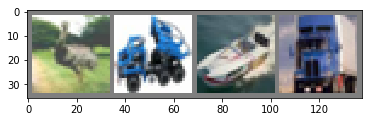

GroundTruth:   bird truck  ship truck


In [22]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# visualize image
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [23]:
mynet = MyNet()
mynet.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [24]:
outputs = mynet(images)

In [27]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:   deer truck  ship truck


This is not bad, we have 3/4 right answers.

In [28]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = mynet(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (labels == predicted).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


According to the result, we have 5% better than chance

In [29]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = mynet(images)
        _, predicted = torch.max(outputs, 1)
        c = (labels == predicted).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 69 %
Accuracy of   car : 80 %
Accuracy of  bird : 36 %
Accuracy of   cat : 32 %
Accuracy of  deer : 65 %
Accuracy of   dog : 39 %
Accuracy of  frog : 61 %
Accuracy of horse : 65 %
Accuracy of  ship : 56 %
Accuracy of truck : 51 %
